In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:

class ImageDataLoader(Sequence):
    def __init__(self, input_dir, target_dir, filenames, batch_size, img_size=(300, 300)):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.filenames = filenames
        self.batch_size = batch_size
        self.img_size = img_size
    
    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        x = []
        y = []
        for file_name in batch_x:
            input_img = cv2.imread(os.path.join(self.input_dir, file_name))
            input_img = cv2.resize(input_img, self.img_size) / 255.0
            
            target_img = cv2.imread(os.path.join(self.target_dir, file_name), cv2.IMREAD_GRAYSCALE)
            target_img = cv2.resize(target_img, self.img_size) / 255.0
            
            unique_values = np.unique(target_img)
            if not np.array_equal(unique_values, [0, 1]):
                _, target_img = cv2.threshold(target_img, 0.5, 1, cv2.THRESH_BINARY)
            
            target_img = np.expand_dims(target_img, axis=-1)
            
            x.append(input_img)
            y.append(target_img)
        
        return np.array(x), np.array(y)


In [ ]:
# Custom metrics
def pixel_accuracy(y_true, y_pred):
    y_pred = K.round(y_pred)
    correct_pixels = K.sum(K.equal(y_true, y_pred))
    total_pixels = K.prod(K.shape(y_true))
    return correct_pixels / total_pixels

def iou(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / union

def dice_coef(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection) / (K.sum(y_true) + K.sum(y_pred))

def specificity(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_negatives = K.sum((1 - y_true) * (1 - y_pred))
    possible_negatives = K.sum(1 - y_true)
    return true_negatives / possible_negatives

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Combined loss
def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [ ]:
from tensorflow.keras.layers import Conv2DTranspose

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    # U-Net model
    def unet_model(input_shape):
        inputs = Input(input_shape)
        c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        p1 = MaxPooling2D((2, 2))(c1)
        c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
        p2 = MaxPooling2D((2, 2))(c2)
        c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)

        # Use Conv2DTranspose for upsampling
        u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
        u2 = Concatenate()([u2, c2])
        c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

        # Use Conv2DTranspose for upsampling
        u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
        u1 = Concatenate()([u1, c1])
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

        return Model(inputs, outputs)
    model = unet_model((300, 300, 3))
    model.compile(optimizer='adam', loss=combined_loss, 
              metrics=['accuracy', dice_coef, iou, Precision(), Recall(), specificity])

    model.summary()

In [ ]:
# model = unet_model((300, 300, 3))
# model.compile(optimizer='adam', loss=combined_loss, 
#               metrics=['accuracy', dice_coef, iou, Precision(), Recall(), specificity])

# model.summary()

In [ ]:
# Create a new instance of ImageDataLoader
input_dir = '/kaggle/input/anemic-rbc-dataset-complete/Anemic_RBC_dataset/AneRBC-I/Original_Images/anemic/'
target_dir= '/kaggle/input/anemic-rbc-dataset-complete/Anemic_RBC_dataset/AneRBC-I/Binary_Segmented/anemic/'


all_image_filenames = os.listdir(input_dir)
train_filenames, val_filenames = train_test_split(all_image_filenames, test_size=0.2, random_state=42)


In [ ]:
import os
import shutil

# Define source and destination directories
src_dir_original = "/kaggle/input/anemic-rbc-dataset-complete/Anemic_RBC_dataset/AneRBC-I/Original_Images/healthy/"
dest_dir_original = "/kaggle/working/Original_Images_anemic/"

src_dir_segmented = "/kaggle/input/anemic-rbc-dataset-complete/Anemic_RBC_dataset/AneRBC-I/Binary_Segmented/healthy/"
dest_dir_segmented = "/kaggle/working/Binary_Segmented_anemic/"

# Create destination directories if they don't exist
os.makedirs(dest_dir_original, exist_ok=True)
os.makedirs(dest_dir_segmented, exist_ok=True)

# Copy images to writable directories
for file_name in os.listdir(src_dir_original):
    shutil.copy(os.path.join(src_dir_original, file_name), dest_dir_original)

for file_name in os.listdir(src_dir_segmented):
    shutil.copy(os.path.join(src_dir_segmented, file_name), dest_dir_segmented)

# Apply mogrify command on copied images
!mogrify -strip {dest_dir_original}*.png
!mogrify -strip {dest_dir_segmented}*.png


In [ ]:
# Create a new instance of ImageDataLoader
input_dir = '/kaggle/working/Original_Images_anemic/'
target_dir= '/kaggle/working/Binary_Segmented_anemic/'


all_image_filenames = os.listdir(input_dir)
train_filenames, val_filenames = train_test_split(all_image_filenames, test_size=0.2, random_state=42)

In [ ]:
batch_size = 64

train_data_loader = ImageDataLoader(input_dir, target_dir, train_filenames, batch_size)
val_data_loader = ImageDataLoader(input_dir, target_dir, val_filenames, batch_size)

history = model.fit(train_data_loader, validation_data=val_data_loader, epochs=300)

In [ ]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Unet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Unet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Display the plot
plt.tight_layout()  # Adjusts subplot params for better layout
plt.show()

# Save the plot in a directory with high resolution
save_path = '/kaggle/working/plot.png'
plt.savefig(save_path, dpi=300)  # Save with 300 dpi for high resolution

print(f"Plot saved to {save_path}")


In [ ]:
# Extract the training history
hist = history.history

# Calculate the average for each metric over all epochs
avg_accuracy = np.mean(hist['accuracy'])
avg_loss = np.mean(hist['loss'])
avg_dice_coef = np.mean(hist['dice_coef'])
avg_iou = np.mean(hist['iou'])
avg_precision = np.mean(hist['precision_2'])
avg_recall = np.mean(hist['recall_2'])
avg_specificity = np.mean(hist['specificity'])

# Print the results
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Loss: {avg_loss:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coef:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")


In [ ]:
plt.figure(figsize=(12, 8))

# Plot training & validation accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Unet Model Accuracy (AneRBC-II)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Unet Model Loss (AneRBC-II)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Add more plots if you want to visualize other metrics like Dice Coefficient, IoU, etc.

plt.tight_layout()

# Save the figure in high definition
save_path = "/kaggle/working/Unet_Training_AneRBC2.png"  # Update with your desired path and filename
plt.savefig(save_path, dpi=300)  # 300 dpi is a good resolution for HD

plt.show()


In [ ]:
# Plot training & validation IoU
plt.subplot(2, 3, 4)
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('Unet IoU (AneRBC-II)')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

# Save the figure in high definition
save_path = "/kaggle/working/iou_AneRBC2.png"  
plt.savefig(save_path, dpi=300)  

plt.show()

In [ ]:
# Plot training & validation Dice Coefficient
plt.subplot(2, 3, 3)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Unet Dice Coefficient (AneRBC-II)')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()

# Save the figure in high definition
save_path = "/kaggle/working/dc_AmeRBC2.png"  
plt.savefig(save_path, dpi=300)  

plt.show()

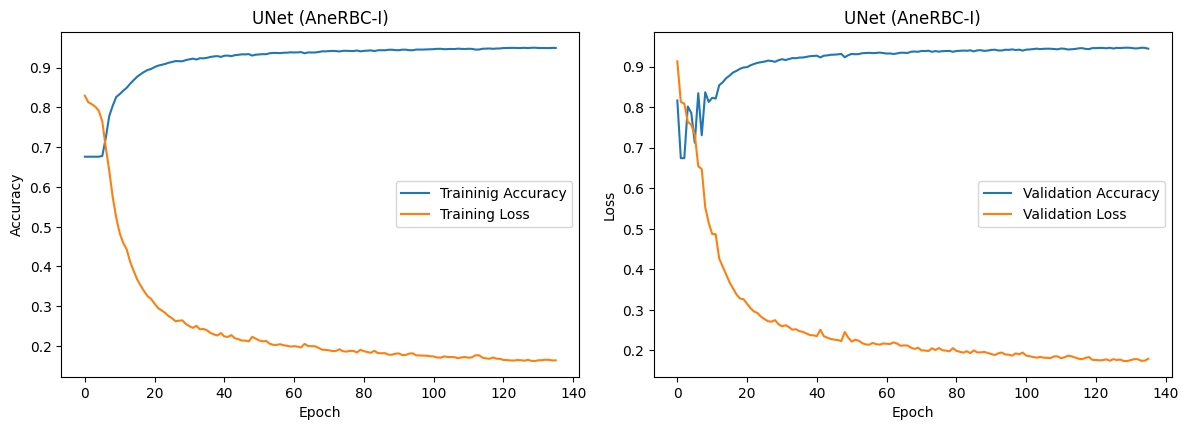

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/kaggle/input/unet-anerbc1-result/Training.csv')  # Replace 'path_to_your_csv_file.csv' with the path to your CSV file

# Create a dictionary to simulate the 'history.history' structure
history = {
    'Accuracy': df['Accuracy'].tolist(),
    ' val_accuracy': df[' val_accuracy'].tolist(),
    'Loss': df['Loss'].tolist(),
    ' val_loss': df[' val_loss'].tolist(),
    ' iou': df[' iou'].tolist(),
    ' val_iou': df[' val_iou'].tolist(),
    ' dice_coef': df[' dice_coef'].tolist(),
    ' val_dice_coef': df[' val_dice_coef'].tolist()
}

plt.figure(figsize=(12, 8))

# Plot training & validation accuracy
plt.subplot(2, 2, 1)
plt.plot(history['Accuracy'])
plt.plot(history['Loss'])
plt.title('UNet (AneRBC-I)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Traininig Accuracy', 'Training Loss'], loc='center right')

# Plot training & validation loss
plt.subplot(2, 2, 2)
plt.plot(history[' val_accuracy'])
plt.plot(history[' val_loss'])
plt.title('UNet (AneRBC-I)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation Accuracy', 'Validation Loss'], loc='center right')

plt.tight_layout()
save_path = "/kaggle/working/Unet_Training_AneRBC1.png"
plt.savefig(save_path, dpi=300)
plt.show()




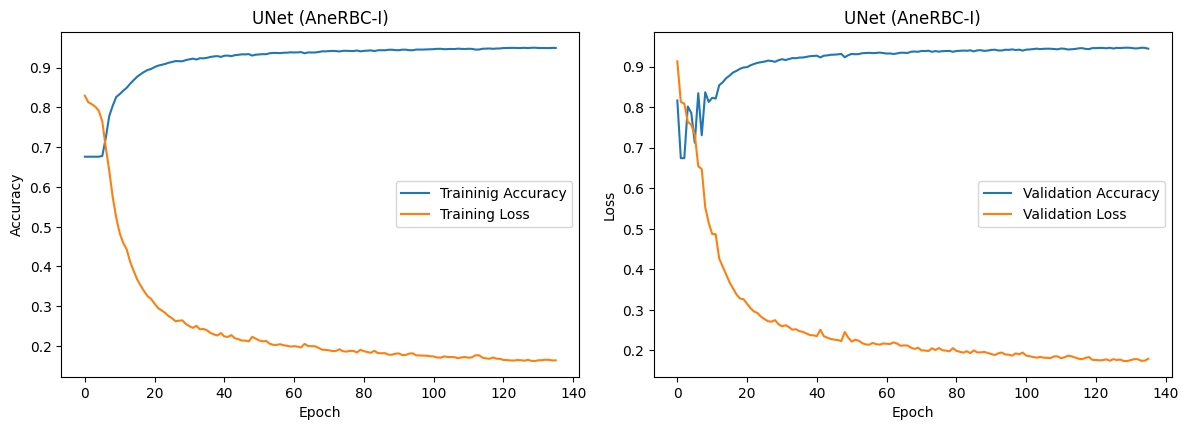

In [9]:
plt.figure(figsize=(12, 8))

# Plot training & validation accuracy
plt.subplot(2, 2, 1)
plt.plot(history['Accuracy'])
plt.plot(history['Loss'])
plt.title('UNet (AneRBC-I)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Traininig Accuracy', 'Training Loss'], loc='center right')

# Plot training & validation loss
plt.subplot(2, 2, 2)
plt.plot(history[' val_accuracy'])
plt.plot(history[' val_loss'])
plt.title('UNet (AneRBC-I)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation Accuracy', 'Validation Loss'], loc='center right')

plt.tight_layout()
save_path = "/kaggle/working/Unet_Training_AneRBC2New.png"
plt.savefig(save_path, dpi=300)
plt.show()

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/kaggle/input/unet-anerbc1-result/Training.csv')  # Replace with the path to your CSV file

# Convert the DataFrame columns to lists for plotting
accuracy = df['Accuracy'].tolist()
val_accuracy = df[' val_accuracy'].tolist()
loss = df['Loss'].tolist()
val_loss = df[' val_loss'].tolist()
iou = df[' iou'].tolist()
val_iou = df[' val_iou'].tolist()
dice_coef = df[' dice_coef'].tolist()
val_dice_coef = df[' val_dice_coef'].tolist()




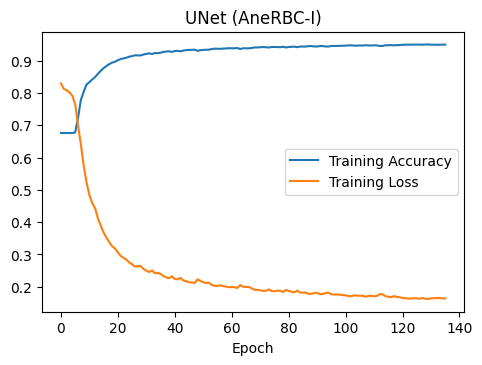

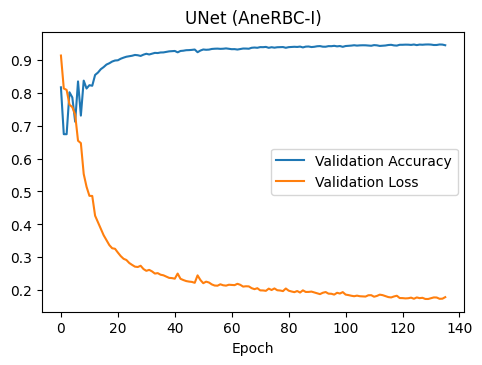

In [11]:
# 1) Training accuracy vs training loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(loss, label='Training Loss')
plt.title('UNet (AneRBC-I)')
plt.xlabel('Epoch')
plt.legend(loc='center right')
save_path = "/kaggle/working/Training_Accuracy_vs_Loss_AneRBC1.png"
plt.savefig(save_path, dpi=300)
plt.show()

# 2) Validation accuracy vs Validation loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.plot(val_loss, label='Validation Loss')
plt.title('UNet (AneRBC-I)')
plt.xlabel('Epoch')
plt.legend(loc='center right')
save_path = "/kaggle/working/Validation_Accuracy_vs_Loss_AneRBC1.png"
plt.savefig(save_path, dpi=300)
plt.show()


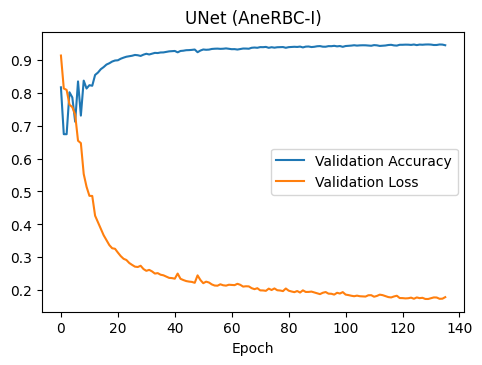

In [12]:

# 2) Validation accuracy vs Validation loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.plot(val_loss, label='Validation Loss')
plt.title('UNet (AneRBC-I)')
plt.xlabel('Epoch')
plt.legend(loc='center right')
save_path = "/kaggle/working/Validation_Accuracy_vs_Loss_AneRBC1.png"
plt.savefig(save_path, dpi=300)
plt.show()


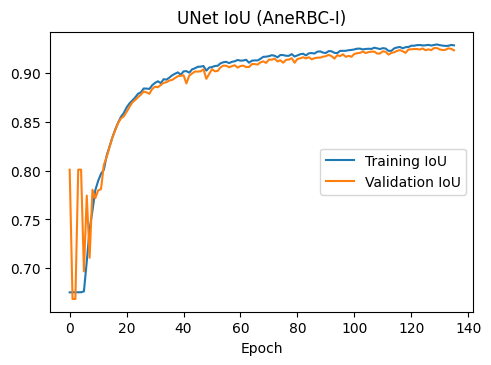

In [13]:
# 3) Training & validation IoU
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 3)
plt.plot(iou, label='Training IoU')
plt.plot(val_iou, label='Validation IoU')
plt.title('UNet IoU (AneRBC-I)')
plt.xlabel('Epoch')
plt.legend(loc='center right')
save_path = "/kaggle/working/Training_Validation_IoU_AneRBC1.png"
plt.savefig(save_path, dpi=300)
plt.show()



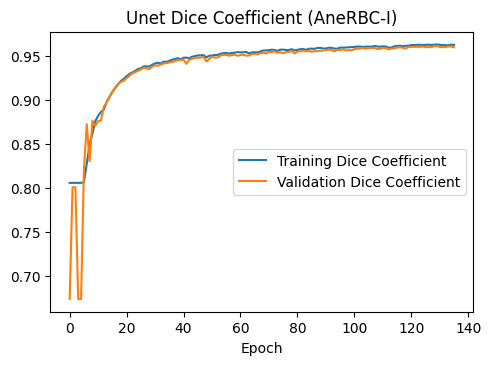

In [14]:
# 4) Training & validation Dice Coefficient
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 4)
plt.plot(dice_coef, label='Training Dice Coefficient')
plt.plot(val_dice_coef, label='Validation Dice Coefficient')
plt.title('Unet Dice Coefficient (AneRBC-I)')
plt.xlabel('Epoch')
plt.legend(loc='center right')
save_path = "/kaggle/working/Training_Validation_DiceCoefficient_AneRBC1.png"
plt.savefig(save_path, dpi=300)
plt.show()